<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook 06 - Food Vision: Transfer Learning Fine Tuning

TK - show what we're doing (the steps) 

- Introduce transfer learning (a way to beat all of our old self-built models)
- Start with 10% of 10 classes
- Then go into:
  - 10% of 100 classes with transfer learning (a big dawg model)
- Ways to prevent overfitting/improve
  - How to continue training a model from a certain point (e.g. how does a model train for more epochs after already training for 10 epochs)
  - Data augmentation
  - EarlyStopping
  - Regularization (more images)

- Extensions:
  - Look into fine-tuning versus training the top layer

## TK - What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [ ]:
# Are we using a GPU?
!nvidia-smi

## Creating helper functions

* TK - change this into importing a helper file - is it possible to clone a single file from GitHub? - https://stackoverflow.com/questions/37353458/cloning-a-single-file-from-github-repo
* TK - also change to be same style as previous notebook

In [3]:
# Create tensorboard callback (need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
# TK - turn this into a helper functiont to load in with a helper.py script
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

TK - is this needed since we are going to create a notebook to download all of the data for the course?

Since in this notebook we're going to be downloading multiple different sources of as zip files and unzipping it, let's create a helper function to unzip files.

In [5]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [17]:
# TK Get the compare historys function from the previous notebook
def compare_historys(original_history, new_history, initial_epochs=5):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

### Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [8]:
# TK change URL + save to drive so someone doesn't have to redownload the data
# !wget https://www.dropbox.com/s/9m3xsmgecj43zml/101_food_classes_10_percent.zip

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-01-21 05:54:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625899818 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   178MB/s    in 9.0s    

2021-01-21 05:55:06 (172 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625899818/1625899818]



As before our data comes in the common image data format of:

```
# Example of file structure
10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 

## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [22]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [11]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

Beautiful! We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [18]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

TK - image of the model we've created (similar picture to the data augmentation built-in to EfficientNetB0

Model created. Let's inspect it.

In [19]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`efficientnetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [23]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings 
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 57s 221ms/step - loss: 1.6132 - accuracy: 0.6123 - val_loss: 1.9262 - val_accuracy: 0.5024
Epoch 2/5
237/237 [==============================] - 51s 213ms/step - loss: 1.4537 - accuracy: 0.6466 - val_loss: 1.8840 - val_accuracy: 0.5064
Epoch 3/5
237/237 [==============================] - 52s 217ms/step - loss: 1.3558 - accuracy: 0.6656 - val_loss: 1.8670 - val_accuracy: 0.5103
Epoch 4/5
237/237 [==============================] - 50s 211ms/step - loss: 1.2605 - accuracy: 0.6915 - val_loss: 1.8813 - val_accuracy: 0.5106
Epoch 5/5
237/237 [==============================] - 51s 214ms/step - loss: 1.1874 - accuracy: 0.7024 - val_loss: 1.8342 - val_accuracy: 0.5199


Woah! It looks like our model is getting some impressive results, but remember, during training our model only evaluated on 15% of the test data. Let's see how it did on the whole test dataset.

In [24]:
# Evaluate model 
model.evaluate(test_data)

790/790 [==============================] - 100s 126ms/step - loss: 1.6356 - accuracy: 0.5667


[1.6356477737426758, 0.5666930675506592]

Well it looks like **we just beat our baseline with 10% of the data**! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

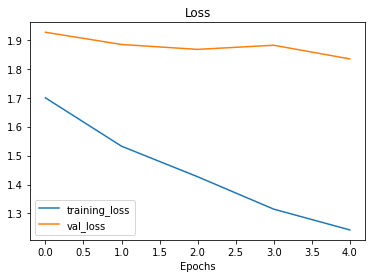

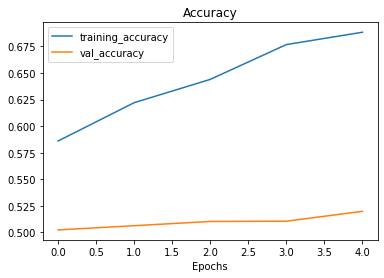

In [25]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [26]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

TK - diagram of fine-tuning (lowering the LR by 10x, show which layers are unfrozen on efficient graphic)

In [27]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

Model recompiled, how about we make sure the layers we want are trainable?

In [28]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [29]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [30]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 58s 224ms/step - loss: 1.0701 - accuracy: 0.7260 - val_loss: 1.8890 - val_accuracy: 0.5130
Epoch 6/10
237/237 [==============================] - 51s 214ms/step - loss: 0.9367 - accuracy: 0.7481 - val_loss: 1.8800 - val_accuracy: 0.5169
Epoch 7/10
237/237 [==============================] - 51s 211ms/step - loss: 0.8663 - accuracy: 0.7631 - val_loss: 1.8944 - val_accuracy: 0.5185
Epoch 8/10
237/237 [==============================] - 51s 212ms/step - loss: 0.8062 - accuracy: 0.7864 - val_loss: 1.9222 - val_accuracy: 0.5122
Epoch 9/10
237/237 [==============================] - 50s 210ms/step - loss: 0.7800 - accuracy: 0.7883 - val_loss: 1.9111 - val_accuracy: 0.5207
Epoch 10/10
237/237 [==============================] - 50s 211ms/step - loss: 0.7333 - accuracy: 0.8017 - val_loss: 1.9328 - val_accuracy: 0.5156


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [31]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 99s 126ms/step - loss: 1.6470 - accuracy: 0.5766


[1.6469982862472534, 0.5765940546989441]

Hmm... it seems like our model got a slight boost from fine-tuning. 

We might get a better picture by using our `compare_historys()` function and seeing what the training curves say.

5
11
[0.5860065817832947, 0.6220462322235107, 0.6439604163169861, 0.676699697971344, 0.688316822052002, 0.7201319932937622, 0.7409901022911072, 0.7596039772033691, 0.7798019647598267, 0.7873267531394958, 0.8006600737571716]


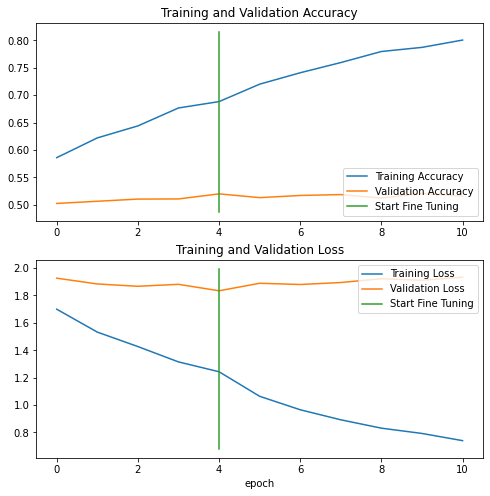

In [32]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

### Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [ ]:
# # Save model to drive so it can be used later 
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/assets


## Evaluting the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

TK - make saved model avaiable online (mine is currently saved in drive but how would someone get it to download it?)

In [ ]:
import tensorflow as tf
# Note: this will output a lot of 'WARNINGS', these can be ignored 
model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/")

To make sure our loaded model is indead a trained model, let's evaluate its performance on the test dataset.

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 87s 110ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

Wonderful! It looks like our loaded model is performing just as well as it was before we saved it. Let's make some predictions.

### Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 83s 105ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

So if we had 25250 images in the test dataset, how many predictions do you think we should have?

In [ ]:
# How many predictions are there?
len(pred_probs)

25250

And if each image could be one of 101 classes, how many predictions do you think we'll have for each image?

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

What we've got is often referred to as a **predictions probability tensor** (or array).

Let's see what the first 10 look like.

In [ ]:
# How do they look?
pred_probs[:10]

array([[5.9542239e-02, 3.5742496e-06, 4.1377138e-02, ..., 1.4138695e-09,
        8.3531238e-05, 3.0897574e-03],
       [9.6401691e-01, 1.3753274e-09, 8.4780384e-04, ..., 5.4286738e-05,
        7.8362516e-12, 9.8466402e-10],
       [9.5925862e-01, 3.2533891e-05, 1.4867031e-03, ..., 7.1891259e-07,
        5.4397464e-07, 4.0276071e-05],
       ...,
       [4.7313330e-01, 1.2931214e-07, 1.4805662e-03, ..., 5.9750152e-04,
        6.6968940e-05, 2.3469418e-05],
       [4.4572014e-02, 4.7265442e-07, 1.2258509e-01, ..., 6.3498633e-06,
        7.5318308e-06, 3.6778823e-03],
       [7.2438955e-01, 1.9249660e-09, 5.2311039e-05, ..., 1.2291407e-03,
        1.5792714e-09, 9.6395474e-05]], dtype=float32)

Alright, it seems like we've got a bunch of tensors of really small numbers, how about we zoom into one of them?

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542239e-02 3.5742496e-06 4.1377138e-02 1.0660627e-09 8.1614990e-09
 8.6639753e-09 8.0927441e-07 8.5652988e-07 1.9859170e-05 8.0978231e-07
 3.1727898e-09 9.8674423e-07 2.8532383e-04 7.8049278e-10 7.4230379e-04
 3.8916529e-05 6.4740930e-06 2.4977426e-06 3.7891317e-05 2.0678429e-07
 1.5538542e-05 8.1507420e-07 2.6230693e-06 2.0010630e-07 8.3827939e-07
 5.4216093e-06 3.7391071e-06 1.3150597e-08 2.7761699e-03 2.8051922e-05
 6.8562622e-10 2.5574835e-05 1.6688929e-04 7.6408102e-10 4.0453265e-04
 1.3150799e-08 1.7957483e-06 1.4448354e-06 2.3063079e-02 8.2467568e-07
 8.5366105e-07 1.7138711e-06 7.0525916e-06 1.8402257e-08 2.8553461e-07
 7.9483543e-06 2.0681794e-06 1.8525277e-07 3.3619870e-08 3.1522708e-04
 1.0411013e-05 8.5448698e-07 8.4741795e-01 1.0555496e-05 4.4095006e-07
 3.7404359e-05 3.5306533e-05 3.2489261e-05 6.7314941e-05 1.2852678e-08
 2.6219937e-10 1.0318160e-05 8.5744126e-05 1.

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.

The final check is to see how many labels we've got.

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

As expected, the number of labels matches the number of images we've got. Time to compare our model's predictions with the ground truth labels.

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

TK - (fix where this function is created) To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [ ]:
# Make confusion matrix
# Note: this function is a modified version of scikit-learn's plot_confusion_matrix - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix 
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# needs a different title to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), fontsize=15, norm=True, savefig=False): 
  # TK - add the docstrings here (sklearn style)
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set_title("Confusion Matrix", fontsize="large")
  ax.set_xlabel("Predicted label", fontsize="large")
  ax.set_ylabel("True label", fontsize="large")

  # ax.set(title="Confusion Matrix",
  #        xlabel="Predicted label",
  #        ylabel="True label",
  ax.set(xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom and rotate for readability
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

  # Adjsut font sizes
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Add text to cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=fontsize)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=fontsize)
  
  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

Right now our predictions and truth labels are in the form of integers, however, they'll be much easier to understand if we get their actual names. We can do so using the `class_names` attribute on our `test_data` object.

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

101 class names and 25250 predictions and ground truth labels ready to go! Looks like our confusion matrix is going to be a big one!

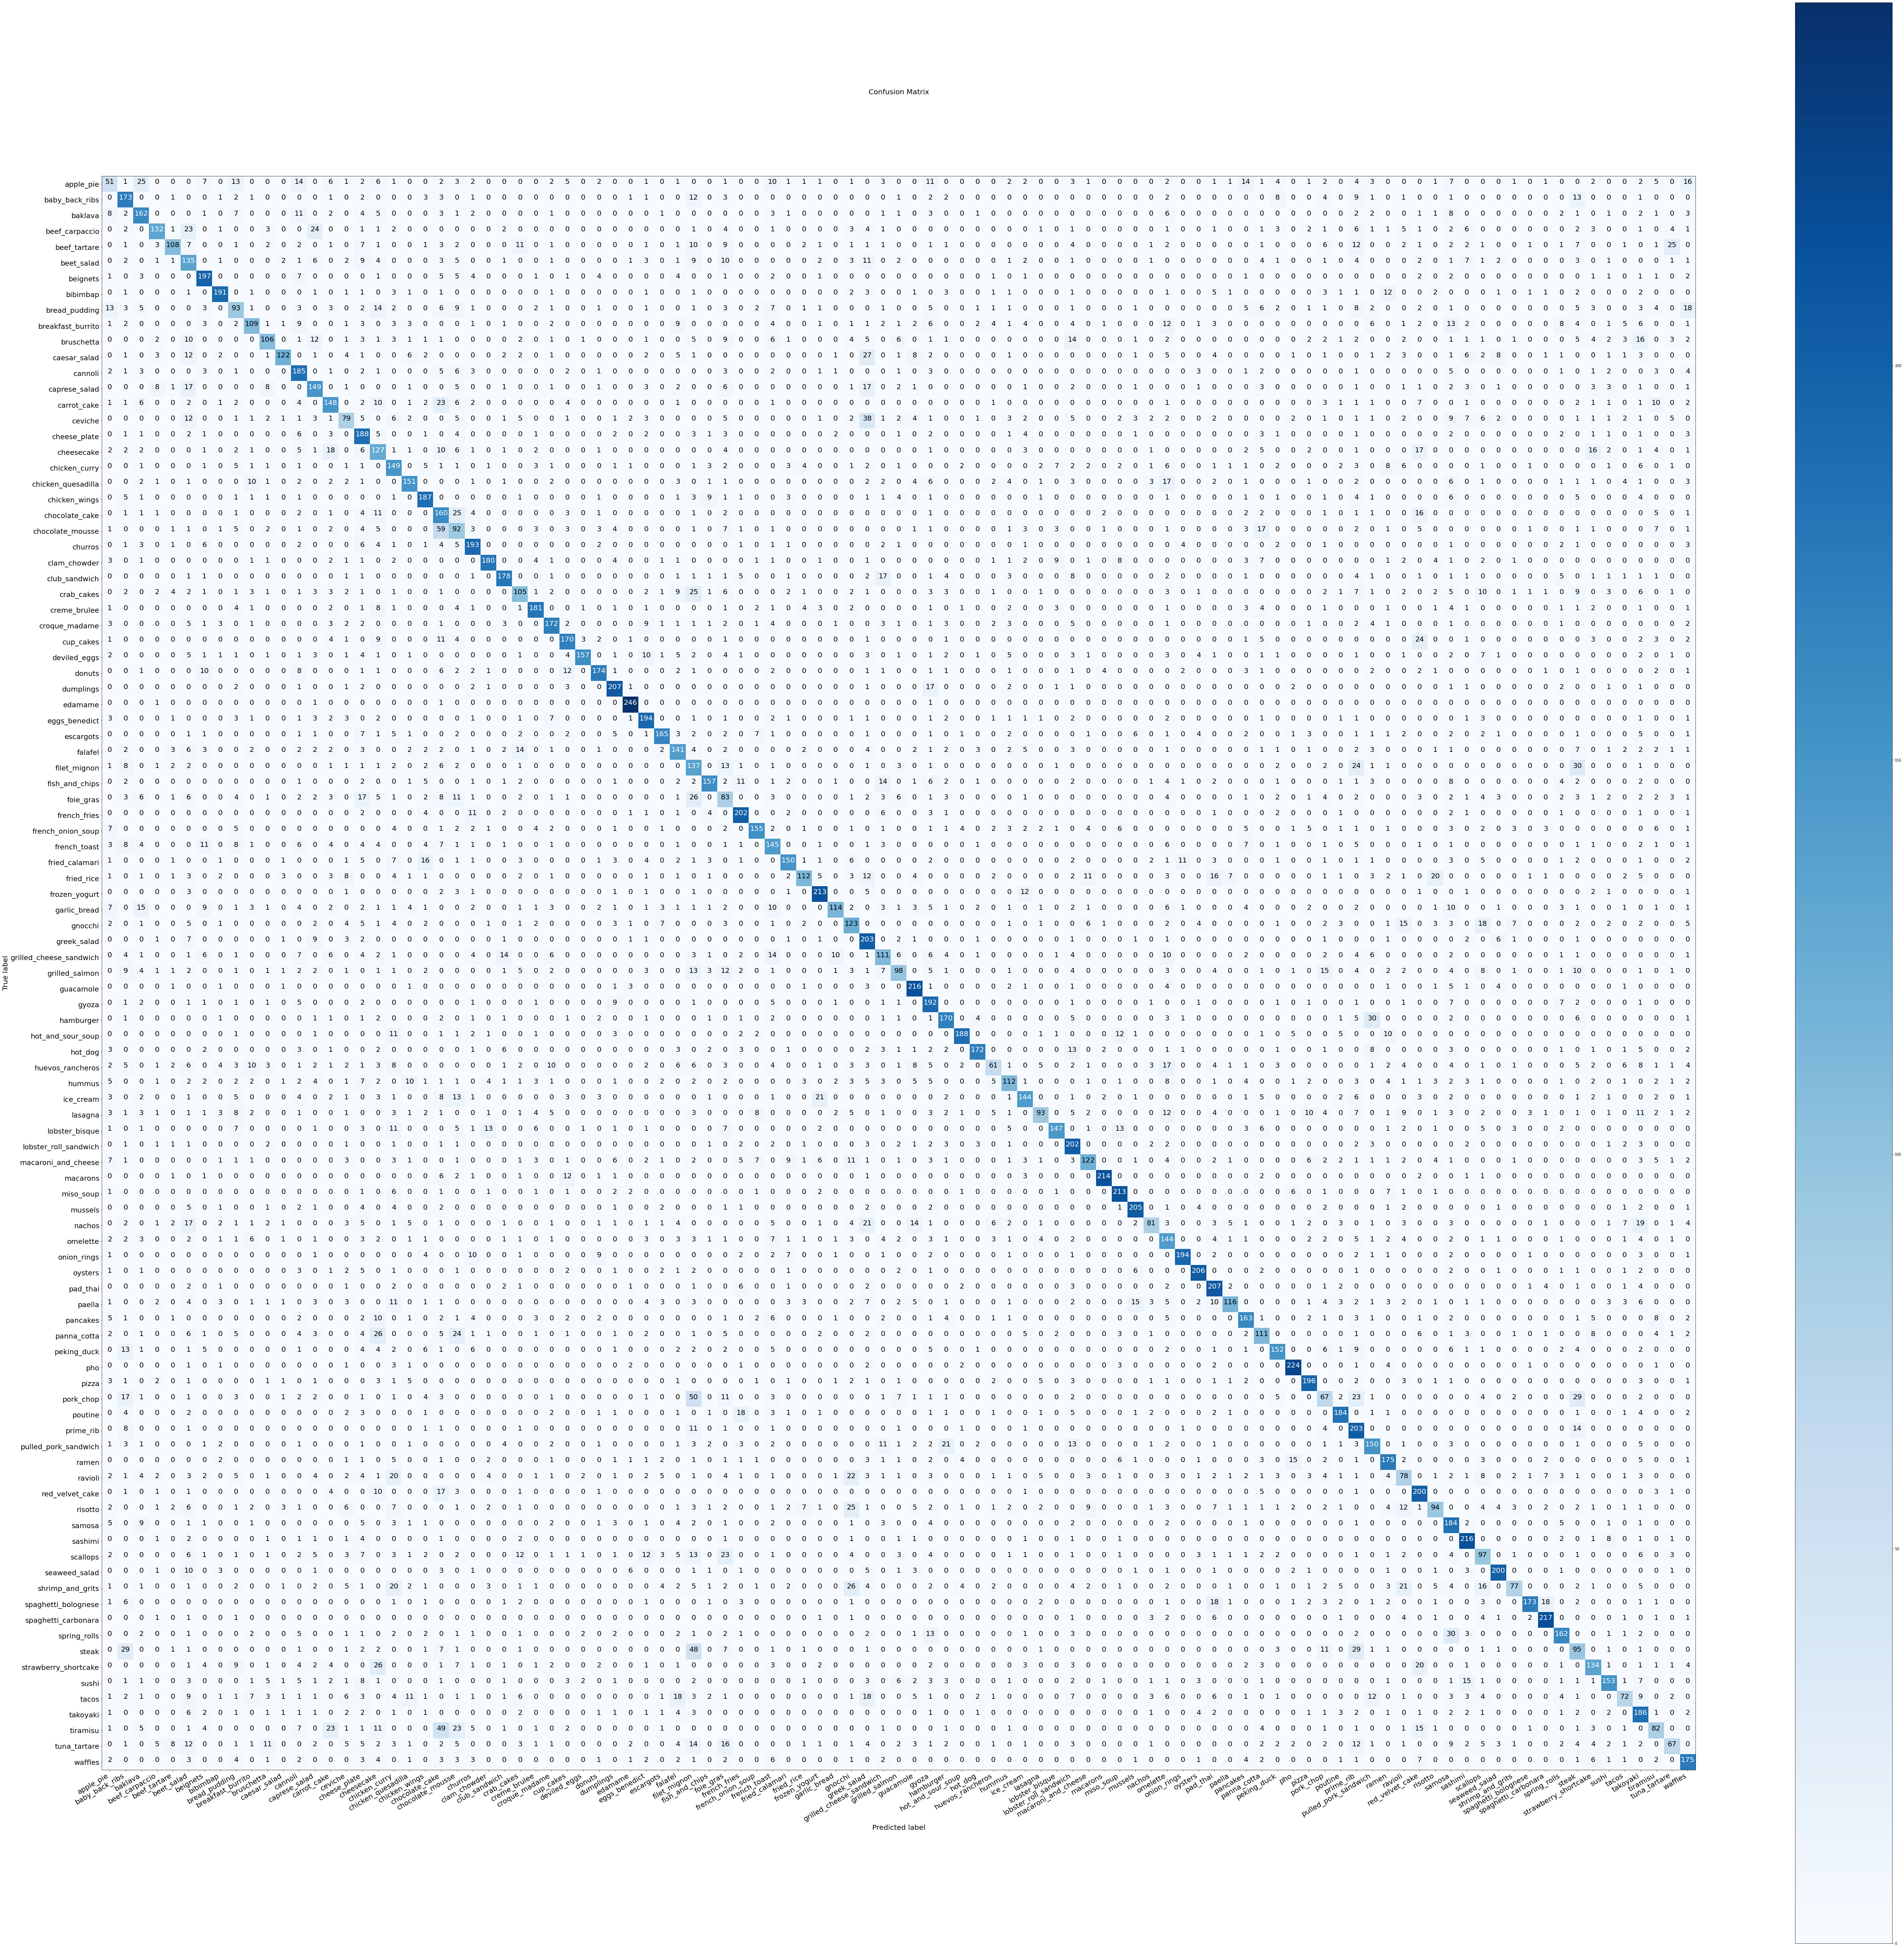

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      fontsize=20,
                      norm=False,
                      savefig=True)

Woah! Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

Alright, there's still a fair few values here, how about we narrow down? 

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

Now we're talking! Let's finish it off with a nice horizontal bar chart.



In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edamame` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

> 🛠 **Exercise:** Visualize some of the most poor performing classes, do you notice any trends among them?


### Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.image.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to: 

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

NameError: ignored

<Figure size 1224x720 with 0 Axes>

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as `baby_back_ribs` getting mistaken as `steak` and vice versa.

### Finding the most wrong predictions

TK - what is most wrong predictions? e.g. where model is very confident but gets the prediction wrong...

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names. 

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367903,apple_pie,prime_rib


Nice! How about we make a simple column telling us whether or not the prediction is right or wrong?

In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367903,apple_pie,prime_rib,False


And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999931,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


Very interesting... just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

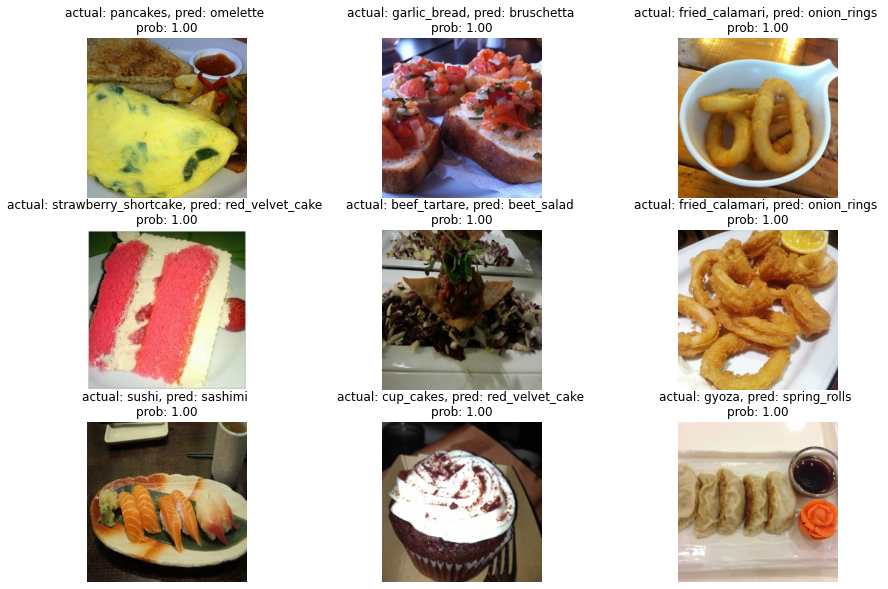

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row
  # y_true = row[5]
  # y_pred = row[6]
  # pred_prob = row[4]
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:
* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food 

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [ ]:
# TK - create folder of custom images in Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2020-09-22 05:52:46--  https://www.dropbox.com/s/ahghakdtqgd64cf/custom_food_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ahghakdtqgd64cf/custom_food_images.zip [following]
--2020-09-22 05:52:46--  https://www.dropbox.com/s/raw/ahghakdtqgd64cf/custom_food_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc31b90c96455237dd391baeff18.dl.dropboxusercontent.com/cd/0/inline/A_2_ZL5ImeI3zTankLtaoS2vVBrLpmnUznk7JD4ovYLpTlpplrmQuk2QFF1nvBtd6_r_SnlCc3erdKETeoQ6xWKmTUG3Ocu4ORIDISUP19S73-oL4tXlAoDMKkDBYGFJd2Y/file# [following]
--2020-09-22 05:52:46--  https://uc31b90c96455237dd391baeff18.dl.dropboxusercontent.com/cd/0/inline/A_2_ZL5ImeI3zTankLtaoS2vVBrLpmnUznk7JD4ovYLpTlpplrmQuk2QFF1nvBtd6_r_SnlCc3erdKETe

Wonderful, we can load these in and turn them into tensors using our `load_and_prep_image()` function but first we need a list of image filepaths.

In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg']

Now we can use similar code to what we used previously to load in our images, make a prediction on each using our trained model and then plot the image along with the predicted class.

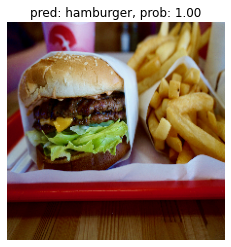

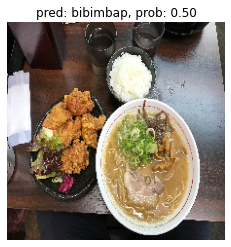

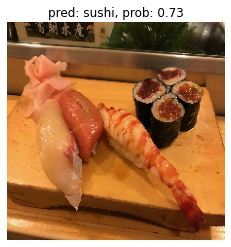

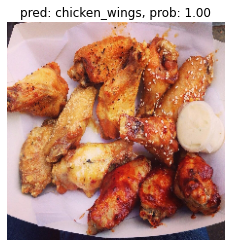

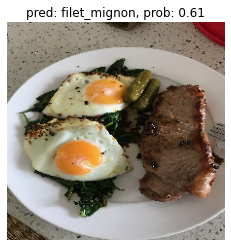

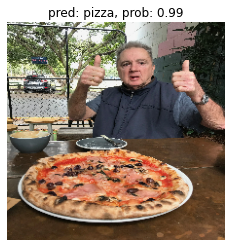

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data?

## 🛠 Exercises

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

## 📖 Extra-curriculum

* Spend 15-minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?
* Spend an hour reading about [Streamlit](https://www.streamlit.io/). What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?